# Feature Selection

Now that we have a good amount of features that we can potentially use in our models, we should consciously think about which ones we want to keep and which ones to exclude. To help us with this process, we can perform correlation analysis.

## Correlation Analysis
### Dataset: 2023-24
We will use a full season's worth of data to perform correlation analysis.

In [1]:
# imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# load in data
fe_23_24 = pd.read_csv('../data/processed/2023-24/feature_engineered_23_24.csv')

In [3]:
# all of our features currently (we might not want all of these to be included in the model)
fe_23_24.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27999 entries, 0 to 27998
Data columns (total 38 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   element                  27999 non-null  int64  
 1   name                     27999 non-null  object 
 2   position                 27999 non-null  object 
 3   GW                       27999 non-null  int64  
 4   total_points             27999 non-null  int64  
 5   value                    27999 non-null  int64  
 6   minutes                  27999 non-null  int64  
 7   expected_goals           27999 non-null  float64
 8   expected_assists         27999 non-null  float64
 9   expected_goals_conceded  27999 non-null  float64
 10  goals_scored             27999 non-null  int64  
 11  assists                  27999 non-null  int64  
 12  goals_conceded           27999 non-null  int64  
 13  clean_sheets             27999 non-null  int64  
 14  ict_index             

### Visualizing Correlations
We will use ```seaborn``` and ```matplotlib``` to plot a correlation matrix between our (numerical) features and the target variable: ```total_points```.

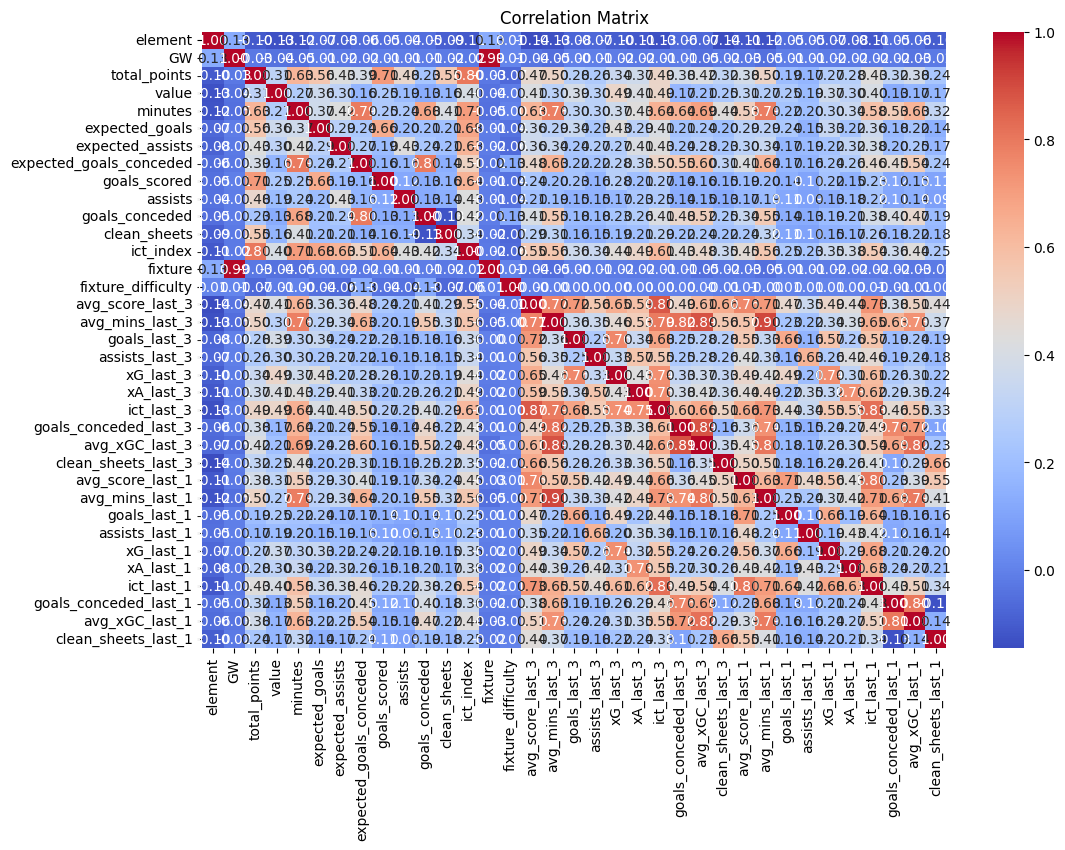

In [4]:
numeric_cols = fe_23_24.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = fe_23_24[numeric_cols].corr()

# plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix")
plt.show()

In [5]:
# as expected, the heatmap is very messy; now let's isolate and focus on each feature's correlation with 'total_points'
target_correlation = correlation_matrix['total_points'].sort_values(ascending=False)
print(target_correlation)

total_points               1.000000
ict_index                  0.803186
goals_scored               0.709938
minutes                    0.628384
expected_goals             0.563301
clean_sheets               0.547853
avg_mins_last_3            0.498473
avg_mins_last_1            0.495619
ict_last_3                 0.493281
assists                    0.481280
avg_score_last_3           0.471409
ict_last_1                 0.433151
expected_assists           0.427000
avg_xGC_last_3             0.416988
expected_goals_conceded    0.391670
avg_score_last_1           0.382616
goals_conceded_last_3      0.382011
avg_xGC_last_1             0.375517
xA_last_3                  0.367887
xG_last_3                  0.343437
clean_sheets_last_3        0.319300
goals_conceded_last_1      0.316526
value                      0.307190
goals_last_3               0.284400
xA_last_1                  0.282698
xG_last_1                  0.270774
assists_last_3             0.257038
clean_sheets_last_1        0

#### Findings / Thoughts

- features with general information (```GW```, ```fixture```, ```element```) should be removed

- since we are predicting points for a future GW, current gameweek features such as ```goals_scored```, ```minutes```, ```ict_index``` or ```assists``` (that are directly associated with gameweek points) should not be used

- however, we see that time-based cumulative features ('last 3...') have strong correlation as well, so we can use them instead

- multicolinearity check: there are some features that are highly correlated (e.g. ```goals_last_3``` vs. ```xG_last_3```), where removing one of them will be beneficial as it can reduce redundancy


### Revised Feature List (ver. 1)
- ```avg_mins_last_x```
- ```avg_score_last_x```
- ```xG_last_x```
- ```xA_last_x```
- ```ict_last_x```
- ```avg_xGC_last_x```
- ```clean_sheets_last_x```
- ```value```
- ```fixture_difficulty```
- ```was_home``` (we will encode this feature)

In [6]:
# revise feature list
fe_23_24 = fe_23_24[[
    'position',
    'minutes',
    'total_points',
    'avg_mins_last_1',
    'avg_mins_last_3',
    'avg_score_last_1',
    'avg_score_last_3',
    'xG_last_1',
    'xG_last_3',
    'xA_last_1',
    'xA_last_3',
    'ict_last_1',
    'ict_last_3',
    'avg_xGC_last_1',
    'avg_xGC_last_3',
    'clean_sheets_last_1',
    'clean_sheets_last_3',
    'value',
    'fixture_difficulty',
    'was_home'
]]

# encode 'was_home'
fe_23_24['was_home'] = fe_23_24['was_home'].astype(int)

### Experiment: Compare Correlation between GK/DEF and MID/FWD
An idea that we've been considering is to train two separate models, one for goalkeepers/defenders and the other for midfielders/forwards, since these two groups have pretty different point scoring structures (i.e. clean sheet points are awarded for GK/DEF). We will look into this by looking at the correlation matrices of these groups separately.

In [7]:
# splitting the data
fe_23_24_gkdef = fe_23_24[fe_23_24['position'].isin(['GK', 'DEF'])]
fe_23_24_midfwd = fe_23_24[fe_23_24['position'].isin(['MID', 'FWD'])]

In [8]:
def corr_analysis(df):
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    correlation_matrix = df[numeric_cols].corr()

    # plotting the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title("Correlation Matrix")
    plt.show()
    
    target_correlation = correlation_matrix['total_points'].sort_values(ascending=False)
    print(target_correlation)

#### Correlation Analysis for Midfielders/Forwards

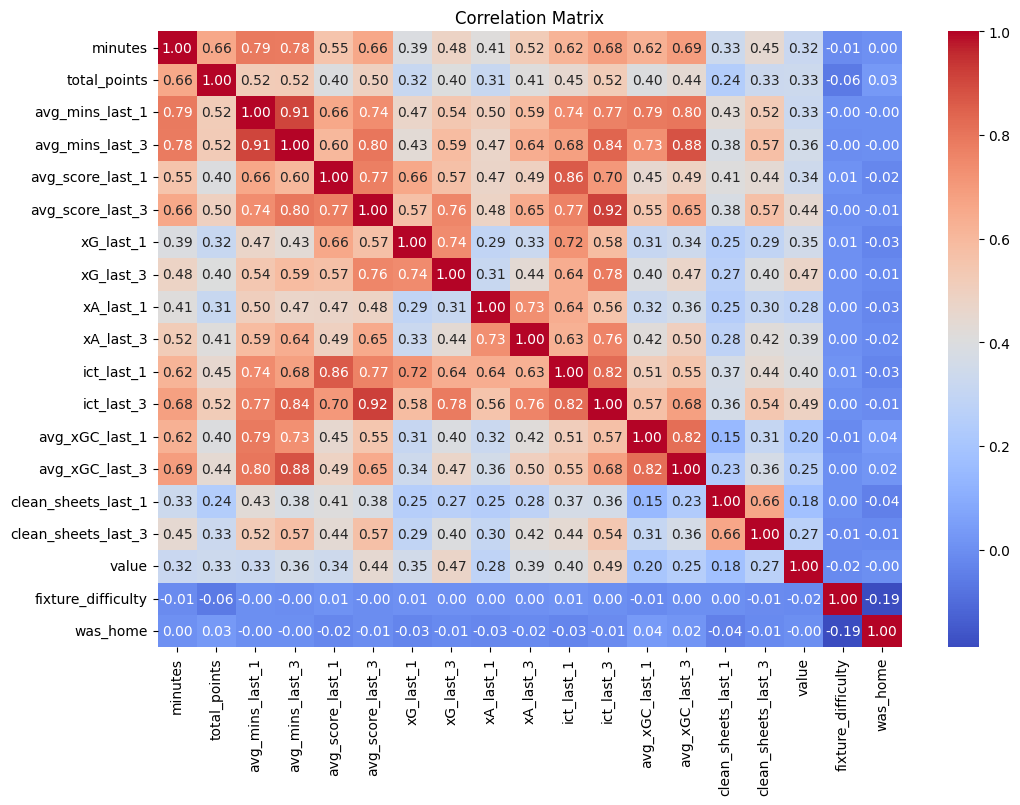

total_points           1.000000
minutes                0.657997
avg_mins_last_3        0.524357
ict_last_3             0.520858
avg_mins_last_1        0.517983
avg_score_last_3       0.497570
ict_last_1             0.450754
avg_xGC_last_3         0.441111
xA_last_3              0.412825
xG_last_3              0.401329
avg_score_last_1       0.399425
avg_xGC_last_1         0.396523
value                  0.331935
clean_sheets_last_3    0.328886
xG_last_1              0.315857
xA_last_1              0.314968
clean_sheets_last_1    0.240262
was_home               0.031025
fixture_difficulty    -0.061357
Name: total_points, dtype: float64


In [9]:
corr_analysis(fe_23_24_midfwd)

#### Correlation Analysis for Goalkeepers/Defenders

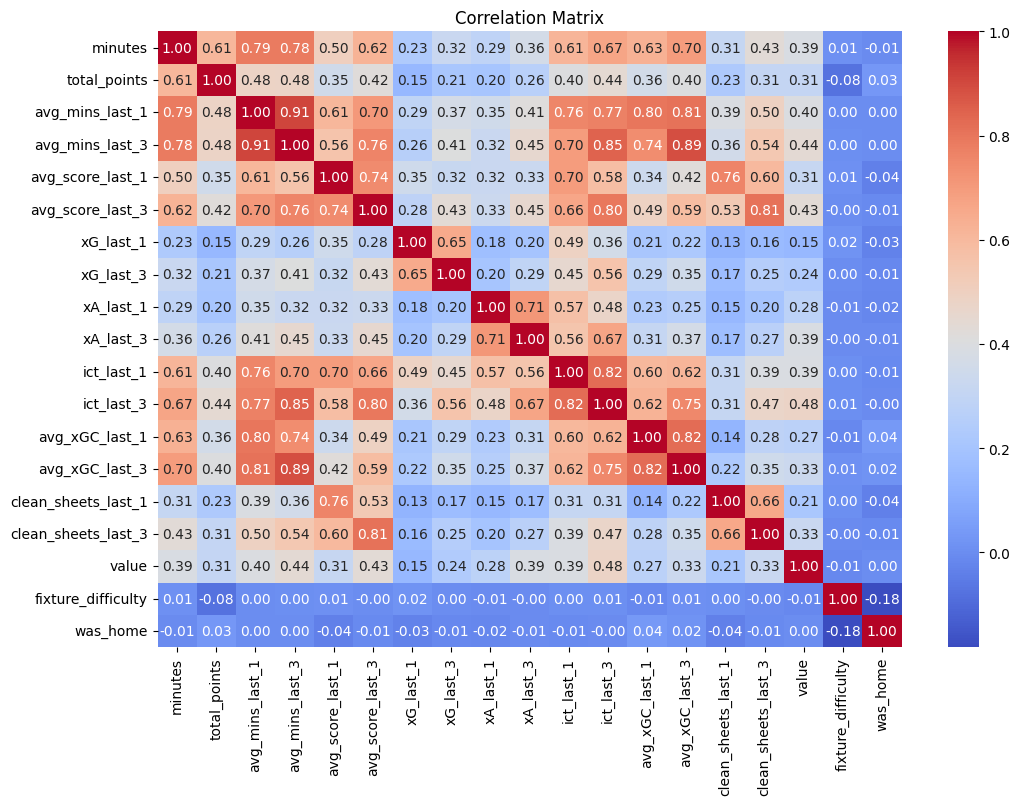

total_points           1.000000
minutes                0.609526
avg_mins_last_1        0.483197
avg_mins_last_3        0.482259
ict_last_3             0.441469
avg_score_last_3       0.420289
avg_xGC_last_3         0.402499
ict_last_1             0.400544
avg_xGC_last_1         0.362311
avg_score_last_1       0.349222
value                  0.305234
clean_sheets_last_3    0.305183
xA_last_3              0.261936
clean_sheets_last_1    0.228273
xG_last_3              0.207521
xA_last_1              0.201962
xG_last_1              0.146924
was_home               0.032906
fixture_difficulty    -0.076718
Name: total_points, dtype: float64


In [10]:
corr_analysis(fe_23_24_gkdef)

#### Findings
- as expected, goals and assists (```xG_last_3```, ```xA_last_3```) have much higher correlation to points for midfielders and forwards (~0.4), compared to goalkeepers and defenders (~0.2)

- surprisingly, goals conceded (```xGC_last_3```) have similar correlation to points for both sets

### Experiment: Only consider data points where ```minutes``` > 0

After taking a closer look at our data, we've discovered that there are many rows of players that did not play. We suspect these rows may be noise that are affecting some of the correlation numbers. Therefore, we will look at the subset of data points with ```minutes```  > 0 and see if the numbers change.

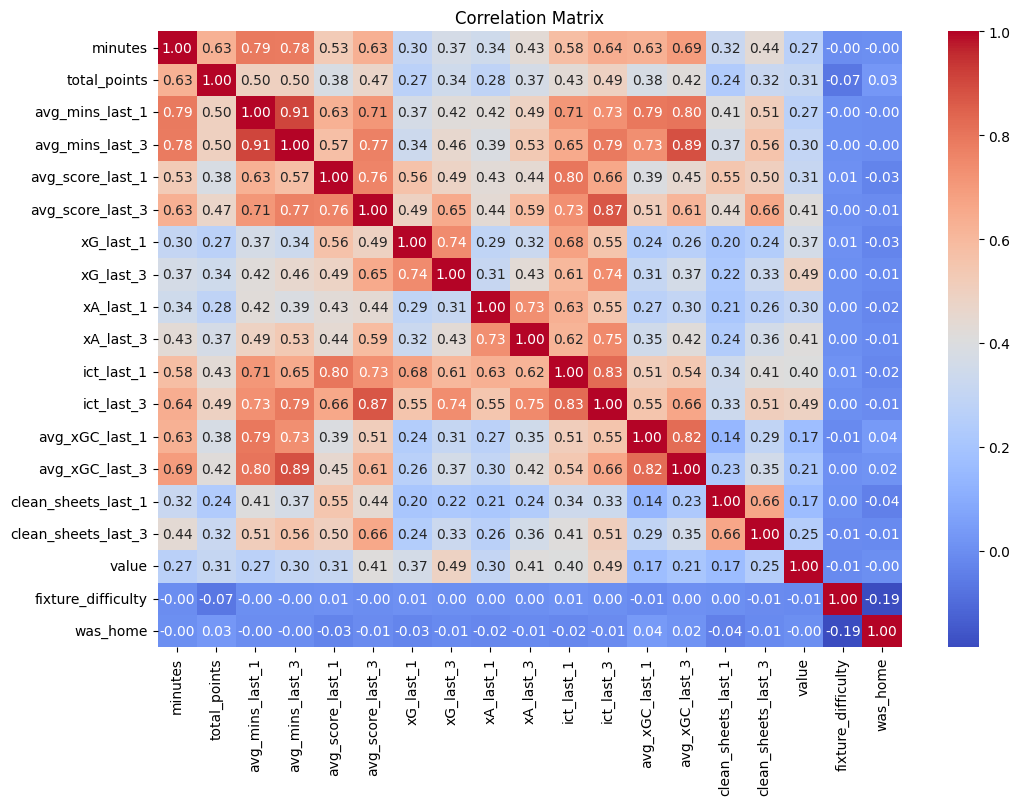

total_points           1.000000
minutes                0.628384
avg_mins_last_3        0.498473
avg_mins_last_1        0.495619
ict_last_3             0.493281
avg_score_last_3       0.471409
ict_last_1             0.433151
avg_xGC_last_3         0.416988
avg_score_last_1       0.382616
avg_xGC_last_1         0.375517
xA_last_3              0.367887
xG_last_3              0.343437
clean_sheets_last_3    0.319300
value                  0.307190
xA_last_1              0.282698
xG_last_1              0.270774
clean_sheets_last_1    0.235231
was_home               0.031670
fixture_difficulty    -0.067214
Name: total_points, dtype: float64


In [11]:
# filter out rows where 'minutes' = 0
fe_23_24_nonzero = fe_23_24[fe_23_24['minutes'] > 0]

corr_analysis(fe_23_24)

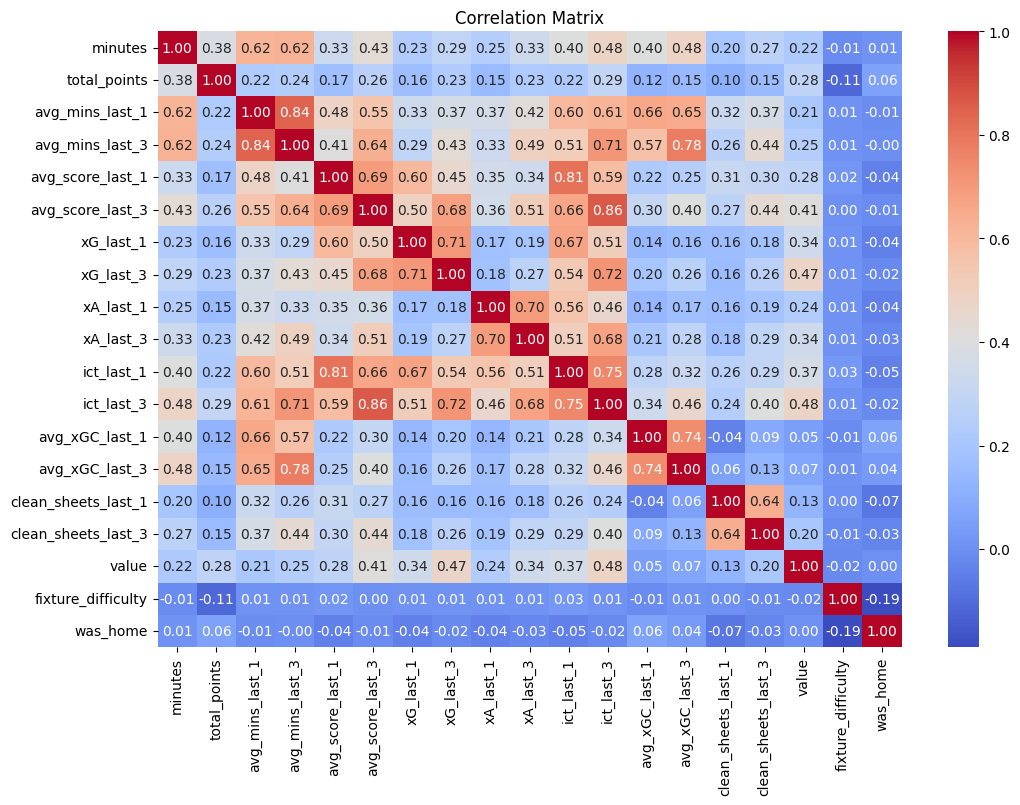

total_points           1.000000
minutes                0.384423
ict_last_3             0.294554
value                  0.282259
avg_score_last_3       0.262079
avg_mins_last_3        0.241926
xG_last_3              0.228767
xA_last_3              0.227777
avg_mins_last_1        0.224298
ict_last_1             0.219279
avg_score_last_1       0.170526
xG_last_1              0.164746
xA_last_1              0.152224
clean_sheets_last_3    0.149892
avg_xGC_last_3         0.147133
avg_xGC_last_1         0.122027
clean_sheets_last_1    0.103882
was_home               0.058382
fixture_difficulty    -0.113722
Name: total_points, dtype: float64


In [12]:
# filter out rows where 'minutes' = 0
fe_23_24_midfwd_nonzero = fe_23_24_midfwd[fe_23_24_midfwd['minutes'] > 0]

corr_analysis(fe_23_24_midfwd_nonzero)

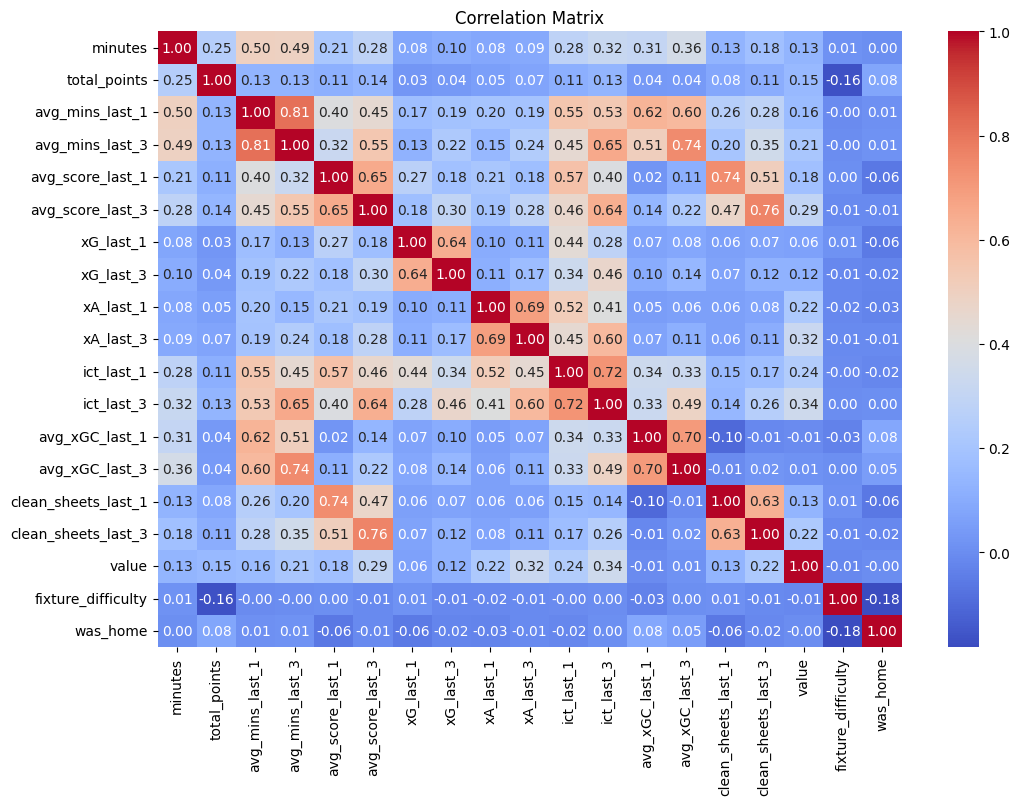

total_points           1.000000
minutes                0.250951
value                  0.153959
avg_score_last_3       0.138562
ict_last_3             0.134571
avg_mins_last_1        0.129456
avg_mins_last_3        0.127442
avg_score_last_1       0.114513
ict_last_1             0.111847
clean_sheets_last_3    0.106217
clean_sheets_last_1    0.084941
was_home               0.076048
xA_last_3              0.074147
xA_last_1              0.053424
avg_xGC_last_3         0.040834
xG_last_3              0.038694
avg_xGC_last_1         0.038354
xG_last_1              0.028305
fixture_difficulty    -0.164343
Name: total_points, dtype: float64


In [13]:
# filter out rows where 'minutes' = 0
fe_23_24_gkdef_nonzero = fe_23_24_gkdef[fe_23_24_gkdef['minutes'] > 0]

corr_analysis(fe_23_24_gkdef_nonzero)

#### Findings

After removing rows of players who did not play, we notice that:

- ```avg_xGC_last_x``` still seems to have low correlation to points, so we should probably remove it

- ```fixture_difficulty``` has a much higher correlation to points now, so we should keep it

- ```was_home``` has low correlation to points, so we should probably remove it

## Verdict on Feature Selection

**We will train one model for all players (for now).**

**We will FILTER OUT rows where ```minutes``` = 0.**

**Final list of features:**
- ```value```
- ```avg_score_last_1```
- ```avg_score_last_3```
- ```ict_last_1```
- ```ict_last_3```
- ```avg_mins_last_1```
- ```avg_mins_last_3```
- ```xG_last_1```
- ```xG_last_3```
- ```xA_last_1```
- ```xA_last_3```
- ```clean_sheets_last_1```
- ```clean_sheets_last_3```
- ```fixture_difficulty```

### Transforming Our Data (again)

In [14]:
def feature_selection(df):
    # filter out rows where minutes = 0
    df = df[df['minutes'] > 0]

    # select relevant features
    df = df[[
        'element',
        'name',
        'position',
        'GW',
        'total_points',
        'value',
        'avg_score_last_1',
        'avg_score_last_3',
        'ict_last_1',
        'ict_last_3',
        'avg_mins_last_1',
        'avg_mins_last_3',
        'xG_last_1',
        'xG_last_3',
        'xA_last_1',
        'xA_last_3',
        'clean_sheets_last_1',
        'clean_sheets_last_3',
        'fixture_difficulty'
    ]].rename(columns={
        'element':'player_id',
        'name':'full_name',
        'total_points':'gameweek_points'
    })

    return df

#### 2022-23

In [15]:
# load in feature engineered data
feature_engineered_22_23 = pd.read_csv('../data/processed/2022-23/feature_engineered_22_23.csv')

# transform
feature_selected_22_23 = feature_selection(feature_engineered_22_23)

# output
feature_selected_22_23.to_csv('../data/processed/2022-23/feature_selected_22_23.csv', index=False)

#### 2023-24

In [16]:
# load in feature engineered data
feature_engineered_23_24 = pd.read_csv('../data/processed/2023-24/feature_engineered_23_24.csv')

# transform
feature_selected_23_24 = feature_selection(feature_engineered_23_24)

# output
feature_selected_23_24.to_csv('../data/processed/2023-24/feature_selected_23_24.csv', index=False)

#### 2024-25

In [17]:
# load in feature engineered data
feature_engineered_24_25 = pd.read_csv('../data/processed/2024-25/feature_engineered_24_25.csv')

# transform
feature_selected_24_25 = feature_selection(feature_engineered_24_25)

# output
feature_selected_24_25.to_csv('../data/processed/2024-25/feature_selected_24_25.csv', index=False)

#### All Seasons Combined

In [19]:
# add season tag
feature_selected_22_23['season'] = '2022-23'
feature_selected_23_24['season'] = '2023-24'
feature_selected_24_25['season'] = '2024-25'

# concat
feature_selected_combined = pd.concat([feature_selected_22_23, feature_selected_23_24, feature_selected_24_25], ignore_index=True)

# output
feature_selected_combined.to_csv('../data/processed/feature_selected_combined.csv', index=False)